# SEGY

In [1]:
import itertools
import matplotlib.pyplot as plt
from mayavi import mlab
import numpy as np
import pandas as pd
import scipy.ndimage
import segyio
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'mayavi'

3D Post-stack seismic data เป็น a grid of samples ซึ่งถูกเก็บเป็นไฟล์ในรูป SEGY format

## Ideal seismic volumes

Seismic volume ที่จัดการได้ง่ายที่สุดจะมีรูปร่างเป็น perfect rectangular shape และมี inline/xline spacing ที่คงที่

In [2]:
# Import data
base_segy = segyio.open('../data/TNW_small2', ignore_geometry= False)

In [3]:
# Print the text header (known as the EBCDIC)
# It is a human-readable header describing the information on acquisition, processing and geometry
print(segyio.tools.wrap(base_segy.text[0]))

C 1 SEGY OUTPUT FROM Petrel 2017.1 Thursday, November 18 2021 12:55:27
C 2 Name: TNW_3DUHRSsubset_ImperialCollege20211104 Crop 1 Type: 3D seismic    C
3                                                                             C
4 First inline: 2000   Last inline: 2571                                      C
5 First xline:  1316   Last xline:  1839                                      C
6 CRS: Undefined                                                              C
7 X min: 676054.47 max: 676326.12 delta: 271.65                               C
8 Y min: 5987532.19 max: 5987827.05 delta: 294.86                             C
9 Time min: -92.05 max: -47.05 delta: 45.00
C10 Lat min: - max: - delta: -
C11 Long min: - max: - delta: -
C12 Trace min: -92.00 max: -47.10 delta: 44.90
C13 Seismic (template) min: ~-39.39 max: ~66.61 delta: ~106.01
C14 Amplitude (data) min: ~-39.39 max: ~66.61 delta: ~106.01
C15 Trace sample format: IEEE floating point
C16 Coordinate scale factor: 100.00000
C17
C18

In [4]:
data = segyio.tools.cube(base_segy)

In [5]:
type(data)

numpy.ndarray

In [6]:
data.shape

(572, 524, 450)

In [7]:
depth = base_segy.samples 
inlines = base_segy.ilines 
xlines = base_segy.xlines

In [8]:
print("The number of inlines:", inlines.size)
print("The number of crosslines:", xlines.size)
print("Time or depth:", depth.size)

The number of inlines: 572
The number of crosslines: 524
Time or depth: 450


Note: ตำแหน่ง origin (0, 0, 0) อยู่ที่ inline ที่ 2000 และ xline ที่ 1316

เราจะใช้ `mayavi` module สำหรับ 3D visualisation

In [9]:
def explore3d(data_cube, preset=True, I=-1, X=-1, Z=-1):
    """Visualise a seismic volume in 3D""" 
    source = mlab.pipeline.scalar_field(data_cube)
    source.spacing = [1, 1, -1]
    vm = np.percentile(data_cube, 95)  # Remove 5% of high values (should remove all outliers as well)
    
    if preset == True:
        nx, ny, nz = data_cube.shape
        I, X, Z = nx//2, ny//2, nz//2

    mlab.pipeline.image_plane_widget(source,
                                     plane_orientation='x_axes',
                                     slice_index=I,
                                     colormap='coolwarm',
                                     vmin=-vm,
                                     vmax=vm)
    mlab.pipeline.image_plane_widget(source,
                                     plane_orientation='y_axes',
                                     slice_index=X,
                                     colormap='coolwarm',
                                     vmin=-vm,
                                     vmax=vm)
    mlab.pipeline.image_plane_widget(source,
                                     plane_orientation='z_axes',
                                     slice_index=Z,
                                     colormap='coolwarm',
                                     vmin=-vm,
                                     vmax=vm)
    mlab.show()

In [10]:
# Geological features of interest at these locations
I = np.where(inlines == 2285)[0][0]
X = np.where(xlines == 1578)[0][0]
Z = np.where(depth == 60)[0][0]
explore3d(data, preset=False, I=I, X=X, Z=Z)

เมื่อรันเซลล์ด้านบน จะได้หน้าต่างที่แสดง 3D visualisation ดังนี้

<img src="../images/mayavi_demo.png" />

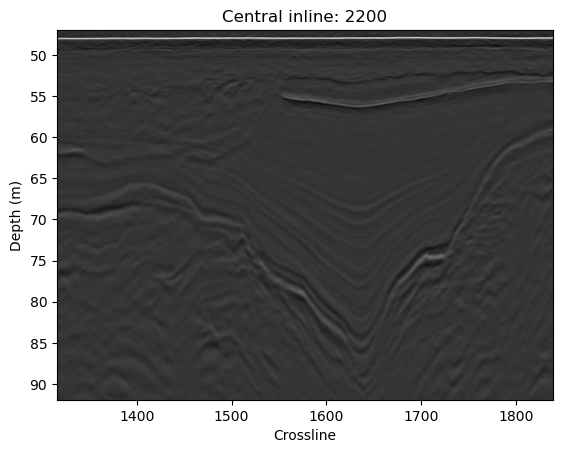

In [11]:
# Visualize the section for inline (y) 2200

boundary = [xlines[0], xlines[-1], depth[-1], depth[0]]  # x_min, x_max, z_min, z_max
y = 2200
inline = data[np.where(inlines == y)[0][0], :, :]  # Pull data for our inline of interest

fig, ax = plt.subplots()
ax.imshow(inline.T, extent=boundary, cmap='gray', aspect='auto')
ax.set(title=f"Central inline: {y}", xlabel="Crossline", ylabel="Depth (m)");

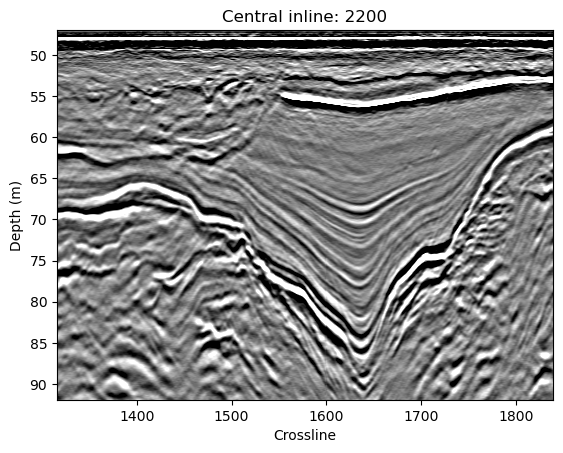

In [12]:
# Enhance the contrast of the section by removing outliers

vm = np.percentile(data, 95)  # Remove 5% of high values (should remove all outliers as well)
boundary = [xlines[0], xlines[-1], depth[-1], depth[0]]  # x_min, x_max, z_min, z_max
y = 2200
inline = data[np.where(inlines == y)[0][0], :, :]  # Pull data for our inline of interest

fig, ax = plt.subplots()
ax.imshow(inline.T, extent=boundary, cmap='gray', aspect='auto', vmin=-vm, vmax=vm)
ax.set(title=f"Central inline: {y}", xlabel="Crossline", ylabel="Depth (m)");

Further questions you can try:
- Visualise your data for xline = 1600 and depth = 70 (try `cmap=seismic` as well)
- Explore the volume to find the positions and get the images of important geological features (e.g., Glacial Channel, possible river channel, mass transport deposit, faults?)

## Non-ideal seismic volumes

สำหรับ unstructured seismic volume เราไม่สามารถเข้าถึง attribute ได้เหมือนกับที่เราทำงานกับ ideal seismic volume

In [13]:
# Import data
base_segy2 = segyio.open('../data/ST0202.segy', ignore_geometry= True)

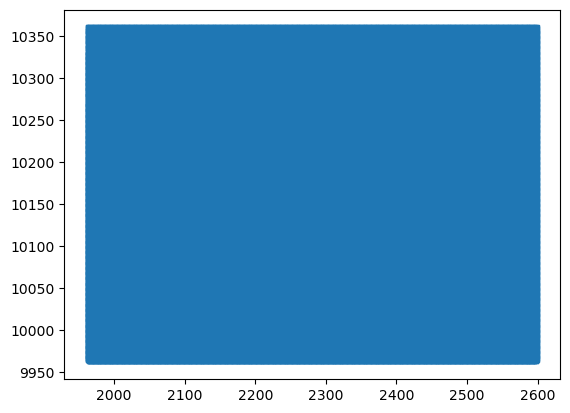

In [14]:
# Explore the imperfectness of the data
inlines, xlines = [], []
for h in base_segy2.header:
    inlines.append(h[segyio.su.iline])
    xlines.append(h[segyio.su.xline])
plt.scatter(xlines, inlines, marker="s", s=1);

จากกราฟด้านบน จะเห็นได้ว่ามี trace ที่หายไปบริเวณมุมล่างซ้ายและล่างขวาของ seismic volume

In [15]:
# Find missing traces - use "set" to remove duplicates
uniqil = set(inlines)
uniqxl = set(xlines)
real = set(zip(inlines, xlines))
grid = set(itertools.product(uniqil, uniqxl))
missing = grid - real
missing

{(9961, 1961),
 (9961, 1962),
 (9961, 2598),
 (9961, 2600),
 (9962, 1961),
 (9962, 1962),
 (9962, 2598),
 (9962, 2600),
 (10273, 1961),
 (10274, 1961),
 (10331, 1961),
 (10332, 1961),
 (10335, 1961),
 (10336, 1961),
 (10339, 1961),
 (10340, 1961),
 (10343, 1961),
 (10344, 1961),
 (10347, 1961),
 (10348, 1961),
 (10351, 1961),
 (10352, 1961),
 (10355, 1961),
 (10356, 1961),
 (10359, 1961),
 (10360, 1961)}

In [16]:
# We now need to put every trace in the right place, which means we need to map
# inline/xline pairs to the right offset in our target array. 
# Had no traces been missing, this is what segyio figures out by default.
ils = sorted(uniqil)
xls = sorted(uniqxl)
lineindex = {(il, xl): i for i, (il, xl) in enumerate(sorted(grid))}
d = np.zeros((len(ils), len(xls), len(base_segy2.samples)))
lineard = d.reshape(d.shape[0] * d.shape[1], d.shape[2])
for il, xl, trace in zip(inlines, xlines, base_segy2.trace[:]):
    lineard[lineindex[il, xl]][:] = trace[:]

In [17]:
# Visualise the fixed volume
explore3d(d)

<img src="../images/mayavi_demo2.png" />